# Lambda School Data Science Module 142
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [1]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 1], [2, 2]]).T
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [2]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=38.69323106073592, pvalue=3.961609200867749e-09)


In [3]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## Live Lecture - let's explore some more of scipy.stats

In [0]:
# Taking requests! Come to lecture with a topic or problem and we'll try it.

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):

1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.

### Initializations

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [2]:
drugs = pd.read_table('drugsComTest_raw.tsv')

In [29]:
drugs.head(5)

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4


In [4]:
drugs.shape

(53766, 7)

In [33]:
# I counted how many treatments are available for each unique condition 
# in the table.
unique_conditions = drugs.condition.unique()

for disease in unique_conditions:
    # number_of_treatments is the number of unique combinations of 
#     treatment and disease, which I then print for each disease.
    number_of_treatments = len(drugs[drugs['condition']==disease].drugName.unique())
    print('{}, {}'.format(disease, number_of_treatments))

Depression, 97
Crohn's Disease, Maintenance, 15
Urinary Tract Infection, 33
Weight Loss, 15
Birth Control, 155
Keratosis, 9
Migraine Prevention, 36
Opiate Withdrawal, 10
Hot Flashes, 17
Vaginal Yeast Infection, 17
Schizoaffective Disorde, 26
Insomnia, 66
Narcolepsy, 20
Smoking Cessation, 13
Acne, 90
Bipolar Disorde, 66
Irritable Bowel Syndrome, 38
Keratoconjunctivitis Sicca, 2
Hyperhidrosis, 9
Panic Disorde, 34
Onychomycosis, Fingernail, 4
Rosacea, 23
Bowel Preparation, 23
Constipation, Drug Induced, 6
nan, 0
Diabetes, Type 2, 77
Pain, 163
Lipodystrophy, 2
Alcohol Dependence, 6
Emergency Contraception, 10
Major Depressive Disorde, 43
Anxiety, 70
Bladder Infection, 19
Benign Prostatic Hyperplasia, 21
Rheumatoid Arthritis, 64
Endometriosis, 39
ADHD, 48
Restless Legs Syndrome, 19
Conjunctivitis, Allergic, 8
Raynaud's Syndrome, 5
Schizophrenia, 32
Diabetes, Type 1, 18
Kidney Infections, 11
Generalized Anxiety Disorde, 16
Obesity, 36
Nausea/Vomiting, 30
Osteoarthritis, 57
Motion Sickness, 9

Bulimia, 4
Pertussis, 1
Pulmonary Embolism, 6
Gout, 7
Pinworm Infection (Enterobius vermicularis), 4
Lennox-Gastaut Syndrome, 3
Intraocular Hypertension, 7
Conjunctivitis, Bacterial, 10
min), 4
Uveitis, 5
3</span> users found this comment helpful., 16
Hidradenitis Suppurativa, 2
Hyperphosphatemia of Renal Failure, 5
Gonococcal Infection, Uncomplicated, 2
Macular Edema, 3
Pancreatic Exocrine Dysfunction, 3
Uterine Fibroids, 4
Xerostomia, 4
Premenstrual Syndrome, 4
Premature Lab, 5
Angina Pectoris Prophylaxis, 2
Intermittent Claudication, 3
Hyperekplexia, 2
Juvenile Idiopathic Arthritis, 5
Dumping Syndrome, 1
Iron Deficiency Anemia, 10
Mania, 8
Chronic Lymphocytic Leukemia, 4
Temporomandibular Joint Disorde, 4
Myelodysplastic Syndrome, 2
Pelvic Inflammatory Disease, 2
Primary Immunodeficiency Syndrome, 5
Nausea/Vomiting, Postoperative, 2
Gender Dysphoria, 1
Ischemic Stroke, Prophylaxis, 3
Bronchospasm Prophylaxis, 4
Mild Cognitive Impairment, 1
Skin and Structure Infection, 9
15</span> u

Periodontitis, 2
Wolff-Parkinson-White Syndrome, 1
Urinary Retention, 1
Head Injury, 1
Sunburn, 1
Hypercalcemia of Malignancy, 1
Prevention of Dental Caries, 2
Dermatophytosis, 1
Hemophilia A, 1
Eosinophilic Esophagitis, 1
Primary Hyperaldosteronism, 1
Breast Cancer, Palliative, 1
Oppositional Defiant Disorde, 1
tic (mycophenolic acid), 1
Submental Fullness, 1
Parkinsonism, 1
Reversal of Nondepolarizing Muscle Relaxants, 1
Nonoccupational Exposure, 1
Cerebral Edema, 1
Yellow Fever Prophylaxis, 1
acial Lipoatrophy, 1
Cataplexy, 2
Cachexia, 1
Stomach Cance, 1
Joint Infection, 1
Status Epilepticus, 1
41</span> users found this comment helpful., 1
Pudendal Neuralgia, 1
Acute Otitis Externa, 1
Small Bowel or Pancreatic Fistula, 1
Steroid Responsive Inflammatory Conditions, 1
135</span> users found this comment helpful., 1
Hyperphosphatemia, 1
Myelofibrosis, 1
Hemophilia B, 1
38</span> users found this comment helpful., 1
Pain/Feve, 1
Thyrotoxicosis, 1
Pertussis Prophylaxis, 1
mist (, 1
Head

In [70]:
# I also counted how many total reviews exist for each disease
unique_conditions = drugs.condition.unique()

for disease in unique_conditions:
    # number_of_treatments is the number of unique combinations of 
#     treatment and disease, which I then print for each disease.
    number_of_reviews = len(drugs[drugs['condition']==disease])
    print('{}, {}'.format(disease, number_of_reviews))

Depression, 3095
Crohn's Disease, Maintenance, 74
Urinary Tract Infection, 431
Weight Loss, 1248
Birth Control, 9648
Keratosis, 45
Migraine Prevention, 454
Opiate Withdrawal, 107
Hot Flashes, 67
Vaginal Yeast Infection, 811
Schizoaffective Disorde, 127
Insomnia, 1231
Narcolepsy, 152
Smoking Cessation, 660
Acne, 1847
Bipolar Disorde, 1380
Irritable Bowel Syndrome, 325
Keratoconjunctivitis Sicca, 26
Hyperhidrosis, 240
Panic Disorde, 469
Onychomycosis, Fingernail, 7
Rosacea, 175
Bowel Preparation, 639
Constipation, Drug Induced, 77
nan, 0
Diabetes, Type 2, 808
Pain, 2100
Lipodystrophy, 3
Alcohol Dependence, 130
Emergency Contraception, 827
Major Depressive Disorde, 524
Anxiety, 1908
Bladder Infection, 130
Benign Prostatic Hyperplasia, 165
Rheumatoid Arthritis, 320
Endometriosis, 192
ADHD, 1126
Restless Legs Syndrome, 240
Conjunctivitis, Allergic, 21
Raynaud's Syndrome, 13
Schizophrenia, 195
Diabetes, Type 1, 45
Kidney Infections, 32
Generalized Anxiety Disorde, 378
Obesity, 1189
Nausea/Vo

Conjunctivitis, Bacterial, 18
min), 15
Uveitis, 8
3</span> users found this comment helpful., 17
Hidradenitis Suppurativa, 3
Hyperphosphatemia of Renal Failure, 5
Gonococcal Infection, Uncomplicated, 2
Macular Edema, 3
Pancreatic Exocrine Dysfunction, 7
Uterine Fibroids, 17
Xerostomia, 8
Premenstrual Syndrome, 7
Premature Lab, 36
Angina Pectoris Prophylaxis, 9
Intermittent Claudication, 3
Hyperekplexia, 2
Juvenile Idiopathic Arthritis, 7
Dumping Syndrome, 2
Iron Deficiency Anemia, 15
Mania, 20
Chronic Lymphocytic Leukemia, 11
Temporomandibular Joint Disorde, 10
Myelodysplastic Syndrome, 6
Pelvic Inflammatory Disease, 4
Primary Immunodeficiency Syndrome, 12
Nausea/Vomiting, Postoperative, 6
Gender Dysphoria, 1
Ischemic Stroke, Prophylaxis, 8
Bronchospasm Prophylaxis, 7
Mild Cognitive Impairment, 3
Skin and Structure Infection, 19
15</span> users found this comment helpful., 5
Vitamin B12 Deficiency, 5
Periodic Limb Movement Disorde, 17
Glioblastoma Multiforme, 2
Hypoestrogenism, 9
Kerat

35</span> users found this comment helpful., 1
105</span> users found this comment helpful., 1
Herpes Simplex, Mucocutaneous/Immunocompromised Host, 1
actor IX Deficiency, 1
Ichthyosis, 1
29</span> users found this comment helpful., 1
Anaplastic Astrocytoma, 1
Acute Nonlymphocytic Leukemia, 1
Epididymitis, Sexually Transmitted, 1
Strongyloidiasis, 1


Looks like there's tens-hundreds of unique treatments, and hundreds-thousands of entries per disease.  To make sure that I have sample sizes in the hundreds, what I'll compare all the ratings of one disease against all the ratings for some others.

In [43]:
def confidence_interval(data, confidence=0.95):
    """
    Calculates the CI for a given set of data.
    
    Arguments:
    data (array-like object that can be turned into a Numpy array)
    confidence (float within the unit interval): the % confidence for 
    the interval to be returned
    
    Returns:
    Tuple of (mean, lower CI, upper CI)
    """
    # The CI is calculated as:
#    Sample mean +/- t(confidence level, degrees of freedom) * SEM

#    If we want the two-tailed 95% CI, the confidence level at either 
#    side of the mean will be half of that, or 2.5%

    data = np.array(data)
    mean = np.mean(data)
    n = len(data)
    confidence_level = (1 + confidence)/2.
    degrees_of_freedom = n-1
    SEM = stats.sem(data)    
    interval = stats.t.ppf(confidence_level, degrees_of_freedom)
    
    return (mean, mean-interval, mean+interval)


    
def rating_CI(condition, confidence=0.95):
    """
    Calculates and returns the confidence interval (CI)
    of the ratings for a given drug.
    
    Arguments:
    condition (string): A condition from the condition column
    confidence (float within the unit interval): the % confidence 
        for the interval to be returned
    
    Returns:
    Tuple of (mean, lower CI, upper CI)
    """
    data = drugs[drugs.condition == condition].rating
    
    return confidence_interval(data, confidence)

Let's find the two diseases with the most different mean ratings, and then plot their histograms and 95% CIs.

In [62]:
unique_conditions = drugs.condition.unique()

# Array of the mean ratings for each unique disease
mean_ratings = [rating_CI(disease)[0] for disease in unique_conditions]


/anaconda3/envs/sandbox/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/sandbox/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/envs/sandbox/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/envs/sandbox/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/envs/sandbox/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [65]:
# The most different mean reviews are the min and max of that array
(min(mean_ratings), max(mean_ratings))

(1.0, 10.0)

Dammit.  Of course there are drugs/treatment combinations out there for which all the reviews are 1 or 0.  Let's limit our search to non-trivial combinations.  How about I limit the search to disease with at least hundreds of reviews?

In [68]:
unique_conditions = drugs.condition.unique()
common_diseases = []

# Populates common_diseases with diseases that have >100 reviews
for disease in unique_conditions:
    number_of_reviews = len(drugs[drugs['condition']==disease])
    if number_of_reviews > 100:
        common_diseases.append(disease)

In [227]:
# list of tuples, where each tuple is (mean rating, disease)
mean_ratings = [(rating_CI(disease)[0], disease )for disease in common_diseases]


print('Worst: {} >> Mean rating: {:0.3}'.format(min(mean_ratings)[1], min(mean_ratings)[0]))
print('Best: {} >> Mean rating: {:0.3}'.format(max(mean_ratings)[1], max(mean_ratings)[0]))

Worst: Vaginal Yeast Infection >> Mean rating: 4.06
Best: Cold Sores >> Mean rating: 8.87


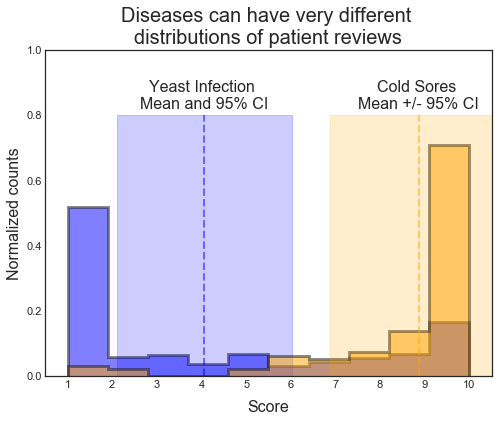

In [194]:
# I plot the two diseases (with at least 100 reviews) that have the best 
# and worst mean reviews.
best_worst = ['Vaginal Yeast Infection','Cold Sores']
labels = ['Yeast Infection \nMean and 95% CI',
          'Cold Sores \nMean +/- 95% CI']
colors = ['blue', 'orange']
plt.style.use('seaborn-white')

fig, ax = plt.subplots(figsize=(8,6))
n_bins = 10


for disease, color, label in zip(best_worst, colors,labels):
    data = drugs[drugs.condition == disease].rating
    ci_numbers = confidence_interval(data)
    ax.hist(data, n_bins, histtype='step',linewidth=3, fill=True, 
            density=True, facecolor=color, alpha=0.5, color='k');
    ax.axvline(ci_numbers[0], linewidth=2, color=color, alpha=0.5, 
               linestyle='--', ymax=0.8)
    ax.axvspan(ci_numbers[1], ci_numbers[2], color=color, alpha=0.2,
               ymax=0.8)
    ax.text(ci_numbers[0], 0.82, label, horizontalalignment='center',
           fontsize=16)


ax.set(ylim=(0,1),xlim=(0.5,10.5), xticks=np.arange(0,11))
ax.set_title('Diseases can have very different \ndistributions of patient reviews', fontsize=20);
ax.set_xlabel('Score', fontdict={'fontsize':16}, labelpad=10);
ax.set_ylabel('Normalized counts', fontdict={'fontsize':16});

In [225]:
# Printout of summary data
for disease in best_worst:
    data = drugs[drugs.condition == disease].rating
    ci_numbers = confidence_interval(data)
    
    print('\n<< {} >>\nMean: {:10.3}\n95% CI:  {:<.3} - {:0.3}'.format(disease, *ci_numbers))


<< Vaginal Yeast Infection >>
Mean:       4.06
95% CI:  2.1 - 6.02

<< Cold Sores >>
Mean:       8.87
95% CI:  6.88 - 10.8


### (Non-technical) Findings

The findings here are modest.  Of all the diseases in the database with more than 100 reviews of some kind, I found the two that had the most different average rating: yeast infection and cold sores. I figured out the interval (95%CI) where I expect to find the average reviews for each disease. Those intervals do not overlap; patients had really different opinions of the treatments for these two diseases. 


#### Assignment goals
[*done*] - Generate and report confidence interval(s), textually and visually

[*done*] - Interpret - write a ~paragraph aimed at a layperson/manager to explain your findings

#### Stretch goals:

[     ] -Write a longer report, e.g. for a blog

[*done*] - Make snazzier graphics 

[     ] -Apply to other data (your project data, past assignments, etc.)